# Hands On - Creating an fMRI analysis workflow from A-Z

The purpose of this section is that you setup a complete fMRI analysis workflow yourself. So that in the end you are able to perform the analysis from A-Z, i.e. from preprocessing to group analysis. This section will cover the analysis part, the previous section ([02a_nipype_handson_preprocessing](02a_nipype_handson_preprocessing)) covers the preprocessing part.

**<span style="color:red">Important</span>**: You will not be able to go through this notebook if you haven't preprocessed your subjects.

I will also use the opportunity to show you some nice additional interfaces/nodes that might not be relevant to your usual analysis, but it's always nice to know that they exist. And hopefully this will encourage you to investigate all other interfaces that Nipype can bring to your fingertip.

Having said all this, you are of course also free to setup your own pipeline. The one that is most useful to you and your everyday research life. The goal is that you learn how to use Nipype and at the end are able to create any workflow you'd like.

# 1st-level Analysis Workflow Structure

In this notebook we will create a workflow that performs 1st-level analysis and normalizes the resulting beta weights to the MNI template. In concrete steps this means:

    1. Specify 1st-level model parameters
    2. Specify 1st-level contrasts
    3. Estimate 1st-level contrasts
    4. Normalize 1st-level contrasts

## Imports

It's always best to have all relevant module imports at the beginning of your script. So let's import what we most certainly need.

In [ ]:
# Get the Node and Workflow object
from nipype import Node, Workflow

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12/spm12_mcr/spm/spm12')

**Note:** Ideally you would also put the imports of all the interfaces that you use here at the top. But as we will develop the workflow step by step, we can also import the relevant modules as we go.

## Create Nodes and Workflow connections

Let's create all the nodes that we need! Make sure to specify all relevant inputs and keep in mind which ones you later on need to connect in your pipeline.

### Workflow for the 1st-level analysis

We recommend to create the workflow and establish all it's connections at a later place in your script. This helps to have everything nicely together. But for this hands on example it makes sense to establish the connections between the nodes as we go.

And for this, we first need to create a workflow:

In [ ]:
# Create the workflow here
# Hint: use 'base_dir' to specify where to store the working directory

In [ ]:
analysis1st = Workflow(name='work_1st', base_dir='/home/neuro/workshop/')

### Specify 1st-level model parameters (stimuli onsets, duration, etc.)

The specify the 1st-level model we need the subject specific onset times and durations of the stimuli. Luckily, as we are working with a BIDS dataset, this information is nicely stored in a `tsv` file:

In [ ]:
import pandas as pd
trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
trialinfo

Using pandas is probably the quickest and easiest ways to aggregate stimuli information per condition.

In [ ]:
for group in trialinfo.groupby('trial_type'):
    print(group)
    print("")

To create a GLM model, Nipype needs an list of `Bunch` objects per session. As we only have one session, our object needs to look as follows:

    [Bunch(conditions=['Finger', 'Foot', 'Lips'],
           durations=[[15.0, 15.0, 15.0, 15.0, 15.0],
                      [15.0, 15.0, 15.0, 15.0, 15.0],
                      [15.0, 15.0, 15.0, 15.0, 15.0]],
           onsets=[[10, 100, 190, 280, 370],
                   [40, 130, 220, 310, 400],
                   [70, 160, 250, 340, 430]]
           )]

For more information see either the [official documnetation](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.algorithms.modelgen.html) or the [nipype_tutorial example](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Specify-GLM-Model).

So, let's create this Bunch object that we then can use for the GLM model.

In [ ]:
import pandas as pd
from nipype.interfaces.base import Bunch

trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
conditions = []
onsets = []
durations = []

for group in trialinfo.groupby('trial_type'):
    conditions.append(group[0])
    onsets.append(list(group[1].onset))
    durations.append(group[1].duration.tolist())

subject_info = [Bunch(conditions=conditions,
                      onsets=onsets,
                      durations=durations,
                      )]
subject_info

Good! Now we can create the node that will create the SPM model. For this we will be using `SpecifySPMModel`. As a reminder the TR of the acquisition is 2.5s and we want to use a high pass filter of 128.

In [ ]:
from nipype.algorithms.modelgen import SpecifySPMModel

In [ ]:
# Initiate the SpecifySPMModel node here

In [ ]:
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=2.5,
                                 high_pass_filter_cutoff=128,
                                 subject_info=subject_info),
                 name="modelspec")

This node will also need some additional inputs, such as the preprocessed functional images, the motion parameters etc. We will specify those once we take care of the workflow data input stream.

### Specify 1st-level contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts (seven T-contrasts and two F-contrasts):

In [ ]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

### Estimate 1st-level contrasts

Before we can estimate the 1st-level contrasts, we first need to create the 1st-level design. Here you can also specify what kind of basis function you want (HRF, FIR, Fourier, etc.), if you want to use time and dispersion derivatives and how you want to model the serial correlation.

In this example I propose that you use an HRF basis function, that we model time derivatives and that we model the serial correlation with AR(1).

In [ ]:
from nipype.interfaces.spm import Level1Design

In [ ]:
# Initiate the Level1Design node here

In [ ]:
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=2.5,
                                 model_serial_correlations='AR(1)'),
                    name="level1design")

Now that we have the Model Specification and 1st-Level Design node, we can connect them to each other:

In [ ]:
# Connect the two nodes here

In [ ]:
analysis1st.connect([(modelspec, level1design, [('session_info',
                                                 'session_info')])])

Now we need to estimate the model. I recommend that you'll use a `Classical: 1` method to estimate the model.

In [ ]:
from nipype.interfaces.spm import EstimateModel

In [ ]:
# Initiate the EstimateModel node here

In [ ]:
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

Now we can connect the 1st-Level Design node with the model estimation node.

In [ ]:
# Connect the two nodes here

In [ ]:
analysis1st.connect([(level1design, level1estimate, [('spm_mat_file',
                                                      'spm_mat_file')])])

Now that we estimate the model, we can estimate the contrasts. Don't forget to feed the list of contrast we specify above to this node.

In [ ]:
from nipype.interfaces.spm import EstimateContrast

In [ ]:
# Initiate the EstimateContrast node here

In [ ]:
level1conest = Node(EstimateContrast(contrasts=contrast_list),
                    name="level1conest")

Now we can connect the model estimation node with the contrast estimation node.

In [ ]:
# Connect the two nodes here

In [ ]:
analysis1st.connect([(level1estimate, level1conest, [('spm_mat_file',
                                                      'spm_mat_file'),
                                                     ('beta_images',
                                                      'beta_images'),
                                                     ('residual_image',
                                                      'residual_image')])])

### Normalize 1st-level contrasts

Now that the contrasts were estimated in subject space we can put them into a common reference space by normalizing them to a specific template. In this case we will be using SPM12's Normalize routine and normalize to the SPM12 tissue probability map `TPM.nii`.

At this step you can also specify the voxel resolution of the output volumes. If you don't specify it, it will normalize to a voxel resolution of 2x2x2mm. As a training exercise, set the voxel resolution to 4x4x4mm.

In [ ]:
from nipype.interfaces.spm import Normalize12

# Location of the template
template = '/opt/spm12/spm12_mcr/spm/spm12/tpm/TPM.nii'

In [ ]:
# Initiate the Normalize12 node here

In [ ]:
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[4, 4, 4]
                            ),
                 name="normalize")

Now we can connect the estimated contrasts to normalization node.

In [ ]:
# Connect the nodes here

In [ ]:
analysis1st.connect([(level1conest, normalize, [('con_images',
                                                 'apply_to_files')])
                     ])

## Datainput with `SelectFiles` and `iterables` 

As in the preprocessing hands on, we will again be using [`SelectFiles`](../../../nipype_tutorial/notebooks/basic_data_input.ipynb#SelectFiles) and [`iterables`](../../../nipype_tutorial/notebooks/basic_iteration.ipynb). So, what do we need?

From the preprocessing pipeline, we need the functional images, the motion parameters and the list of outliers. Also, for the normalization we need the subject specific anatomy.

In [ ]:
# Import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
templates = {'anat': '/data/ds000114/sub-{subj_id}/ses-test/anat/sub-{subj_id}_ses-test_T1w.nii.gz',
             'func': '/home/neuro/workshop/output/preproc/sub-{subj_id}_detrend.nii.gz',
             'mc_param': '/home/neuro/workshop/output/preproc/sub-{subj_id}.par',
             'outliers': '/home/neuro/workshop/output/preproc/art.sub-{subj_id}_outliers.txt'
            }

# Create SelectFiles node
sf = Node(SelectFiles(templates, sort_filelist=True),
          name='selectfiles')

Now we can specify over which subjects the workflow should iterate. As we preprocessed only subjects 1 to 5, we can only them for this analysis.

In [ ]:
# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05']
sf.iterables = [('subj_id', subject_list)]

### Gunzip Node

SPM12 can accept NIfTI files as input, but online if they are not compressed ('unzipped'). Therefore, we need to use a `Gunzip` node to unzip the detrend file and another one to unzip the anatomy image, before we can feed it to the model specification node.

In [ ]:
from nipype.algorithms.misc import Gunzip

In [ ]:
# Initiate the two Gunzip node here

In [ ]:
gunzip_anat = Node(Gunzip(), name='gunzip_anat')
gunzip_func = Node(Gunzip(), name='gunzip_func')

And as a final step, we just need to connect this `SelectFiles` node to the rest of the workflow.

In [ ]:
# Connect SelectFiles node to the other nodes here

In [ ]:
analysis1st.connect([(sf, gunzip_anat, [('anat', 'in_file')]),
                     (sf, gunzip_func, [('func', 'in_file')]),
                     (gunzip_anat, normalize, [('out_file', 'image_to_align')]),
                     (gunzip_func, modelspec, [('out_file', 'functional_runs')]),
                     (sf, modelspec, [('mc_param', 'realignment_parameters'),
                                      ('outliers', 'outlier_files'),
                                      ])
                    ])

## Data output with `DataSink`

Now, before we run the workflow, let's again specify a `Datasink` folder to keep those files that are relevant.

In [ ]:
from nipype.interfaces.io import DataSink

In [ ]:
# Initiate DataSink node here

In [ ]:
# Initiate the datasink node
output_folder = 'output'
datasink = Node(DataSink(base_directory='/home/neuro/workshop/',
                         container=output_folder),
                name="datasink")

In [ ]:
## Use the following substitutions for the DataSink output
substitutions = [('_subj_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

Now the next step is to specify all the output that we want to keep in our output folder `output`. Probably best to keep are the:
- SPM.mat file and the spmT and spmF files from the contrast estimation node
- normalized betas and anatomy

In [ ]:
# Connect nodes to datasink here

In [ ]:
analysis1st.connect([(level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                               ('spmT_images', '1stLevel.@T'),
                                               ('spmF_images', '1stLevel.@F'),
                                              ]),
                     (normalize, datasink, [('normalized_files', 'normalized.@files'),
                                            ('normalized_image', 'normalized.@image'),
                                           ]),
                    ])

## Visualize the workflow

Now that the workflow is finished, let's visualize it again.

In [ ]:
# Create 1st-level analysis output graph
analysis1st.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename='/home/neuro/workshop/work_1st/graph.dot.png')

##  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [ ]:
analysis1st.run('MultiProc', plugin_args={'n_procs': 4})

## Visualize results

First, let's look how well the normalization worked.

In [36]:
%matplotlib inline
import nibabel as nb
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_glass_brain

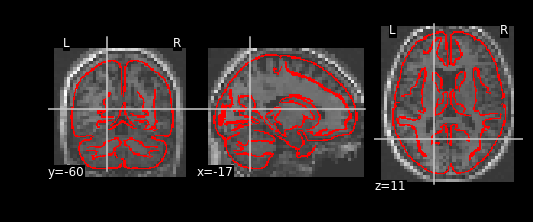

In [40]:
# Load GM probability map of TPM.nii
img = nb.load('/opt/spm12/spm12_mcr/spm/spm12/tpm/TPM.nii')
GM_template = nb.Nifti1Image(img.get_data()[..., 0], img.affine, img.header)

# Plot normalized subject anatomy
display = plot_anat('/home/neuro/workshop/output/normalized/sub-01/wsub-01_ses-test_T1w.nii',
                    dim=-0.1)

# Overlay in edges GM map
display.add_edges(GM_template)

Let's look at the contrasts of one subject that we've just computed. In particular the F-contrast.

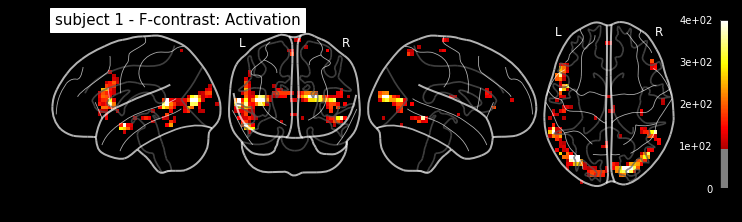

In [41]:
plot_glass_brain('/home/neuro/workshop/output/normalized/sub-01/wess_0008.nii',
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=100,
                 vmax=400, title='subject 1 - F-contrast: Activation');

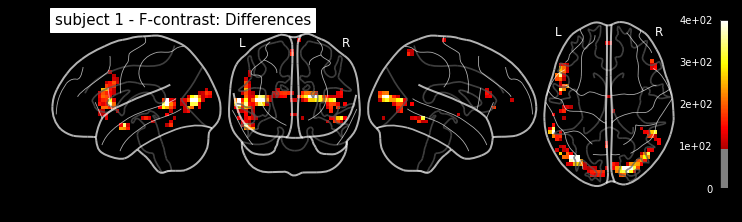

In [42]:
plot_glass_brain('/home/neuro/workshop/output/normalized/sub-01/wess_0009.nii',
                 colorbar=True, display_mode='lyrz', black_bg=True, threshold=100,
                 vmax=400, title='subject 1 - F-contrast: Differences');

# Example 4: 2nd-level Analysis

Last but not least, the 2nd-level analysis. After we removed left handed subjects and normalized all subject data into template space, we can now do the group analysis. To show the flexibility of Nipype, we will run the group analysis on data with two different smoothing kernel (``fwhm= [4, 8]``) and two different normalization (ANTs and SPM).

This example will also directly include thresholding of the output, as well as some visualization.

**Let's start!**

# Group Analysis with SPM

Let's first run the group analysis with the SPM normalized data.

## Imports (SPM12)

First, we need to import all modules we later want to use.

In [ ]:
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype.pipeline.engine import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [ ]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004', 'con_0005', 'con_0006', 'con_0007']

mask = "/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [ ]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [ ]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'norm_spm', 'sub-*_fwhm{fwhm_id}',
                         'w{contrast_id}.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [ ]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

In [ ]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [ ]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 4})

# Visualize results

Now we create a lot of outputs, but how do they look like? And also, what was the influence of different smoothing kernels and normalization?

**Keep in mind, that the group analysis was only done on *`N=7`* subjects, and that we chose a voxel-wise threshold of *`p<0.005`*. Nonetheless, we corrected for multiple comparisons with a cluster-wise FDR threshold of *`p<0.05`*.**

So let's first look at the contrast **average**:

In [ ]:
%matplotlib inline
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0001_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0001_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8',
    bg_img=anatimg, threshold=2, vmax=8, display_mode='y', cut_coords=(-45, -30, -15, 0, 15), cmap='viridis')

The results are more or less what you would expect: The peaks are more or less at the same places for the two normalization approaches and a wider smoothing has the effect of bigger clusters, while losing the sensitivity for smaller clusters.

Now, let's see other contrast -- **Finger > others**. Since we removed left handed subjects, the activation is seen on the left part of the brain.

In [ ]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii', title='ants fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii', title='spm fwhm=4', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii', title='ants fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

plot_stat_map(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii', title='spm fwhm=8', dim=1,
    bg_img=anatimg, threshold=2, vmax=8, cmap='viridis', display_mode='y', cut_coords=(-45, -30, -15, 0, 15))

Now, let's see the results using the glass brain plotting method.

In [ ]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm4/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm4')

plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm4/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm4')

plot_glass_brain(
    '/output/datasink/2ndLevel/spm_con_0005_fwhm8/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='spm_fwhm8')

plot_glass_brain(
    '/output/datasink/2ndLevel/ants_con_0005_fwhm8/spmT_0001_thr.nii',
    threshold=2, display_mode='lyrz', black_bg=True, vmax=10, title='ants_fwhm8')